In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [2]:
def ssvd(X, tol = 1e-3, lambda_us = None, lambda_vs = None, gamma1s = [2], gamma2s = [2], max_iter = 20):
    
    def BIC_v(lambda_v):
        v = abs(v_hat) - lambda_v*w2/2
        df = np.sum(v > 0)
        v[v <= 0] = 0
        v *= np.sign(v_hat)
        return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, v)
    
    def BIC_u(lambda_u):
        u = abs(u_hat) - lambda_u*w1/2
        df = np.sum(u > 0)
        u[u <= 0] = 0
        u *= np.sign(u_hat)
        return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, u)
    
    U, S, V = np.linalg.svd(X, full_matrices = False)
    u = U[:,0][:,None]
    v = V[0,:][:,None]
    s = S[0]
    n, d = X.shape
    nd = n*d
    iter_num = 0
    is_lambda_us_given = lambda_us is not None
    is_lambda_vs_given = lambda_vs is not None
    
    while iter_num < max_iter:
        
        # Update v
        v_hat = X.T @ u
        if all(v_hat == 0):
            v_new = v_hat
        else:
            sigma_sq_hat = np.linalg.norm(X - u @ v_hat.T)**2/(nd-d)
            min_BIC_val = float('inf')
            for gamma2 in gamma2s:
                w2 = np.abs(v_hat)**-gamma2
                if not is_lambda_vs_given:
                    lambda_vs = abs(v_hat)*2/w2
                BIC_vals, v_vals = list(zip(*list(map(BIC_v, lambda_vs))))
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    v_new = v_vals[np.argmin(BIC_vals)]
                    if not all(v_new == 0):
                        v_new = v_new/np.linalg.norm(v_new)
        delta_v_norm = np.linalg.norm(v_new - v)
        v = v_new
        
        # Update u
        u_hat = X @ v
        if all(u_hat == 0):
            u_new = u_hat
        else:
            sigma_sq_hat = np.linalg.norm(X - u_hat @ v.T)**2/(nd-d)
            min_BIC_val = float('inf')
            for gamma1 in gamma1s:
                w1 = np.abs(u_hat)**-gamma1
                if not is_lambda_us_given:
                    lambda_us = abs(u_hat)*2/w1
                BIC_vals, u_vals = list(zip(*list(map(BIC_u, lambda_us))))
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    u_new = u_vals[np.argmin(BIC_vals)]
                    if not all (u_new == 0):
                        u_new = u_new/np.linalg.norm(u_new)
        delta_u_norm = np.linalg.norm(u_new - u)
        u = u_new
        
        iter_num += 1
    
        if (delta_v_norm < tol) and (delta_u_norm < tol):
            break
    
    if (delta_v_norm >= tol) or (delta_u_norm >= tol):
        print("Failed to converge in {} iterations. Try increasing tolerance, or increasing the maximum number of iterations.".format(iter_num))
    
    return u, v, s

# Simulation 1 - Rank 1 Approximation

In [3]:
u_tilde = np.concatenate((np.arange(10,2,-1), 2*np.ones(17), np.zeros(75)))[:,None]
u_true = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.concatenate((np.array([10, -10, 8, -8, 5, -5]), 3*np.ones(5), -3*np.ones(5), np.zeros(34)))[:,None]
v_true = v_tilde/np.linalg.norm(v_tilde)
X_star = 50*u_true*v_true.T
n, d = X_star.shape
np.random.seed(0)
nsims = 100
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)

In [4]:
u_true_labels = u_true == 0
v_true_labels = v_true == 0

In [5]:
ssvd_u_preds, ssvd_v_preds, ssvd_s_values = list(zip(*list(map(ssvd, sims))))

In [6]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds)))*100))

SSVD Misclassification rate for u is 1.27%
SSVD Misclassification rate for v is 0.28%


In [7]:
svd_u_preds, svd_v_preds = list(zip(*list(map(lambda x : (x[0][:,0][:,None], x[2][0,:][:,None]), map(lambda x : np.linalg.svd(x, full_matrices = False), sims)))))

In [8]:
print("SVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), svd_u_preds)))*100))
print("SVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), svd_v_preds)))*100))

SVD Misclassification rate for u is 75.00%
SVD Misclassification rate for v is 68.00%


In [ ]:
# ToDo: Implement and apply other algorithms and compare in Table (Table 1)

# Simulation 2 - Higher Rank Approximation

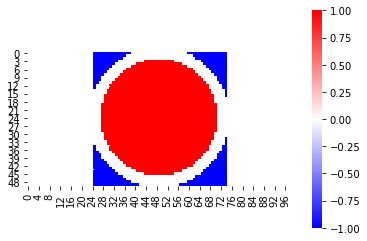

In [3]:
X_star = np.fromfunction(lambda i, j: np.where((25 <= j) & (j <= 74), (24**2 - (i+1-25)**2 - (j+1-50)**2)/100, 0), (50,100)) # like ternary
X_star *= (np.abs(X_star) > 1)
ax = sns.heatmap(X_star, vmin = -1, vmax = 1, cmap = 'bwr', square = True)


In [10]:
nsims = 100
n, d = X_star.shape
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)

In [11]:
sims_copy = copy.deepcopy(sims)
layers = 8
ssvd_estimates = np.empty((layers, nsims, n, d))
for i in range(layers):
    ssvd_predictions = np.array(list(map(lambda x : x[2] * x[0] @ x[1].T, map(lambda x : ssvd(x, tol = 1e-3, max_iter = 40), sims_copy))))
    ssvd_estimates[i] = ssvd_predictions
    sims_copy -= ssvd_predictions

In [12]:
svd_decomps = list(map(lambda x : np.linalg.svd(x, full_matrices = False), sims_copy))
svd_estimates = np.empty((layers, nsims, n, d))
for i in range(layers):
    svd_estimates[i] = np.array(list(map(lambda x : x[1][i] * x[0][:,i][:,None] @ x[2][i,:][None,:],svd_decomps)))

In [13]:
for i in range(1, layers):
    ssvd_estimates[i] += ssvd_estimates[i-1]
    svd_estimates[i] += svd_estimates[i-1]

In [14]:
ssvd_classification = []
ssvd_fro = []
svd_classification = []
svd_fro = []
X_star_labels = X_star == 0
for i in range(layers):
    # Unsure how to get frobenius distance values... 4000?
    ssvd_fro.append(np.mean(list(map(np.linalg.norm, ssvd_estimates[i] - X_star))))
    svd_fro.append(np.mean(list(map(np.linalg.norm, svd_estimates[i] - X_star))))
    ssvd_classification.append(np.mean(list((map(lambda x : np.mean((x == 0) == X_star_labels), ssvd_estimates[i])))))
    svd_classification.append(np.mean(list((map(lambda x : np.mean((x == 0) == X_star_labels), svd_estimates[i])))))

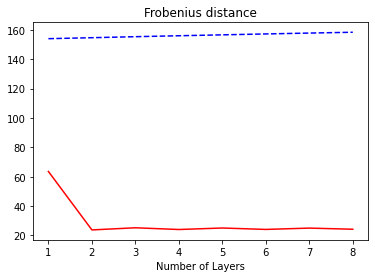

In [15]:
plt.plot(np.arange(1,9), ssvd_fro, label = "SSVD", color = "red")
plt.plot(np.arange(1,9), svd_fro, label = "SVD", color = "blue", linestyle = "dashed")
plt.xlabel("Number of Layers")
plt.title("Frobenius distance");

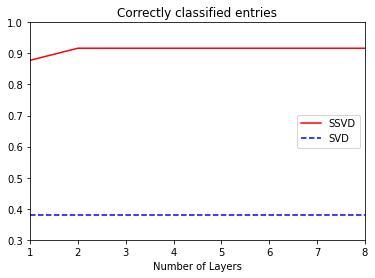

In [16]:
plt.plot(np.arange(1,9), ssvd_classification, label = "SSVD", color = "red")
plt.plot(np.arange(1,9), svd_classification, label = "SVD", color = "blue", linestyle = "dashed")
plt.xlabel("Number of Layers")
plt.ylim([0.3, 1])
plt.xlim([1, 8])
plt.title("Correctly classified entries")
plt.legend();

In [ ]:
# ToDo: Apply RoBiC, Figure out Frobenius distance, and compare with Figure 5

# Lung Cancer Data

In [4]:
X_lung = np.loadtxt('lungcancerdata.txt', delimiter = ' ').T

In [6]:
X_lung.shape

(56, 12625)

In [7]:
u1, v1, s1 = ssvd(X_lung)
X_lung -= s1*(u1 @ v1.T)
u2, v2, s2 = ssvd(X_lung)
X_lung -= s2*(u2 @ v2.T)
u3, v3, s3 = ssvd(X_lung)

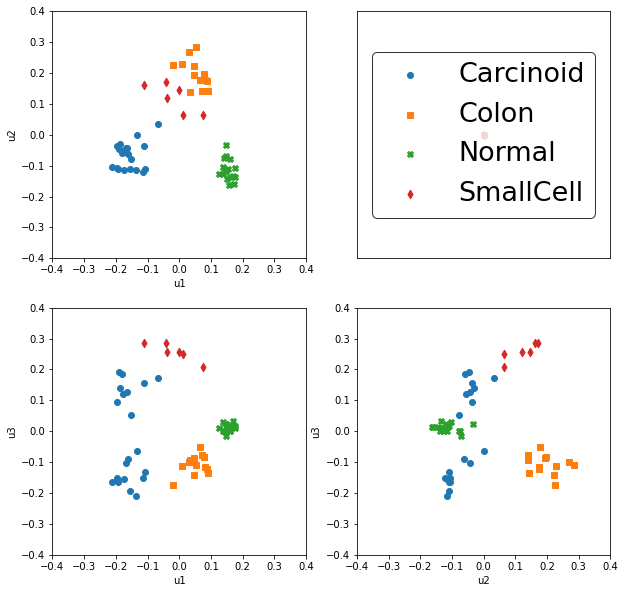

In [9]:
group_indices = [np.arange(20), np.arange(20,33), np.arange(33,50), np.arange(50,56)]
markers = ["o", "s", "X", "d"]
labels = ["Carcinoid", "Colon", "Normal", "SmallCell"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for row in axs:
    for ax in row:
        ax.set_xlim([-0.4, 0.4])
        ax.set_ylim([-0.4, 0.4])
for i in range(len(group_indices)):
    group = group_indices[i]
    axs[0,0].scatter(u1[group], u2[group], marker = markers[i])
    axs[1,0].scatter(u1[group], u3[group], marker = markers[i])
    axs[1,1].scatter(u2[group], u3[group], marker = markers[i])
    axs[0,1].scatter(0, 0, marker = markers[i], label = labels[i])
axs[0,1].legend(loc = 10, fontsize=27).get_frame().set_edgecolor('black')
axs[0,0].set_xlabel("u1")
axs[1,0].set_xlabel("u1")
axs[1,1].set_xlabel("u2")
axs[0,0].set_ylabel("u2")
axs[1,0].set_ylabel("u3")
axs[1,1].set_ylabel("u3")
axs[0,1].set_yticks(()) 
axs[0,1].set_xticks(());

In [34]:
def get_X_for_plotting(u, v, s):
    group_indices = [np.arange(20), np.arange(20,33), np.arange(33,50), np.arange(50,56)]
    for group in group_indices:
        u[group] = np.sort(u[group], axis = 0)

    v_nonzero = v[np.argsort(np.abs(v), axis = 0)[8000:].flatten()]
    v = np.sort(v_nonzero, axis = 0)
    return s * u @ v.T

In [37]:
X1 = get_X_for_plotting(u1, v1, s1)
X2 = get_X_for_plotting(u2, v2, s2)
X3 = get_X_for_plotting(u3, v3, s3)
max_val = np.max(np.abs(np.c_[X1,X2,X3]))
# rescale for increased contrast due to differing colormap
rescale = 3
X1 /= max_val/rescale
X2 /= max_val/rescale
X3 /= max_val/rescale

In [30]:
def plot_lung(X, title, xticks, ax_given, cbar_ax, yticklabels):
    ax = sns.heatmap(X, vmin = -1, vmax = 1, cmap = 'bwr', ax = ax_given, cbar_ax = cbar_ax)
    ax.hlines([20, 33, 50], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.vlines([xticks[0], xticks[1]-8000], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.set_xticks((xticks[0], xticks[1]-8000)) 
    ax.set_xticklabels((str(xticks[0]), str(xticks[1])), rotation = 0)
    ax.set_yticks((10, 27, 42, 53)) 
    ax.set_yticklabels(yticklabels) 
    ax.set_title(title)
    ax.set_xlabel("Ordered gene index");

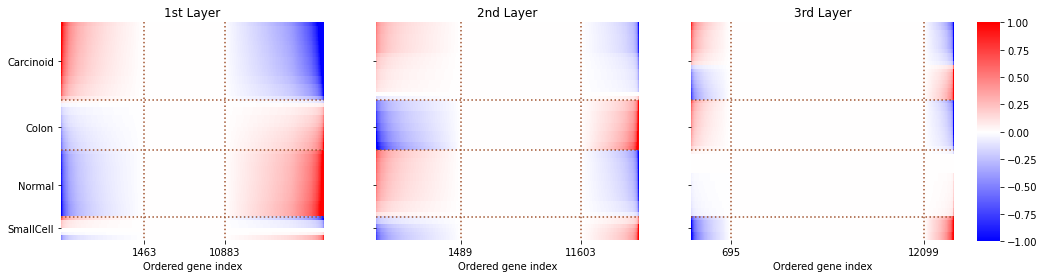

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
cbar_ax = fig.add_axes([.92, .12, .02, 0.76])
plot_lung(X1, "1st Layer", [1463, 10883], ax1, cbar_ax, ("Carcinoid", "Colon", "Normal", "SmallCell"))
plot_lung(X2, "2nd Layer", [1489, 11603], ax2, cbar_ax, ())
plot_lung(X3, "3rd Layer", [695, 12099], ax3, cbar_ax, ())

In [ ]:
# ToDo: Do Figure 3 (probably impossible without access to http://www.unc.edu/~haipeng) and Figure 4. 